In [1]:
import awkward as ak
from coffea import processor
from coffea.nanoevents.methods import candidate
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import json
import hist
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
import pickle, glob
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pyarrow.parquet as pq
import pyarrow as pa 

# Define the CMS color scheme
cms_colors = [
    (0.00, '#FFFFFF'),  # White
    (0.33, '#005EB8'),  # Blue
    (0.66, '#FFDD00'),  # Yellow
    (1.00, '#FF0000')   # red
]

# Create the CMS colormap
cms_cmap = LinearSegmentedColormap.from_list('CMS', cms_colors)


In [10]:
def upsample_array(x, b0, b1):

    r, c = x.shape                                    # number of rows/columns
    rs, cs = x.strides                                # row/column strides
    x = as_strided(x, (r, b0, c, b1), (rs, 0, cs, 0)) # view as a larger 4D array

    return x.reshape(r*b0, c*b1)/(b0*b1)              # create new 2D array with same total occupancy

def resample_EE(imgECAL, factor=2):

    # EE-
    imgEEm = imgECAL[:140-85] # EE- in the first 55 rows
    imgEEm = np.pad(imgEEm, ((1,0),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEm_dn = block_reduce(imgEEm, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEm_dn_up = upsample_array(imgEEm_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor**2
    imgECAL[:140-85] = imgEEm_dn_up[1:] ## replace the old EE- rows

    # EE+
    imgEEp = imgECAL[140+85:] # EE+ in the last 55 rows
    imgEEp = np.pad(imgEEp, ((0,1),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEp_dn = block_reduce(imgEEp, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEp_dn_up = upsample_array(imgEEp_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor*factor
    imgECAL[140+85:] = imgEEp_dn_up[:-1] # replace the old EE+ rows

    return imgECAL

def crop_jet(imgECAL, iphi, ieta, jet_shape=125):

    # NOTE: jet_shape here should correspond to the one used in RHAnalyzer
    off = jet_shape//2
    iphi = int(iphi*5 + 2) # 5 EB xtals per HB tower
    ieta = int(ieta*5 + 2) # 5 EB xtals per HB tower

    # Wrap-around on left side
    if iphi < off:
        diff = off-iphi
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,-diff:],
                                   imgECAL[:,ieta-off:ieta+off+1,:iphi+off+1]), axis=-1)
    # Wrap-around on right side
    elif 360-iphi < off:
        diff = off - (360-iphi)
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,iphi-off:],
                                   imgECAL[:,ieta-off:ieta+off+1,:diff+1]), axis=-1)
    # Nominal case
    else:
        img_crop = imgECAL[:,ieta-off:ieta+off+1,iphi-off:iphi+off+1]

    return img_crop

In [11]:
# ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
# ECAL_energy = resample_EE(ECAL_energy)
# HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
# HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
# TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
# TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
# TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
# PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
# PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
# PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
# PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
# TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
# TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
# TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
# TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
# # X_CMSII            = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TobAtEcal_1, TobAtEcal_2], axis=0) # (13, 280, 360)
# #data['X_CMSII'] = np.stack([TracksAtECAL_pt, ECAL_energy, HBHE_energy], axis=0) # (3, 280, 360)
# #data['X_CMSII'] = np.stack([TracksAtECAL_pt, TracksAtECAL_dz, TracksAtECAL_d0, ECAL_energy], axis=0) # (4, 280, 360)
# #data['X_CMSII'] = np.stack([TracksAtECAL_pt, TracksAtECAL_dz, TracksAtECAL_d0, ECAL_energy, HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4], axis=0) # (9, 280, 360)

# # Jet attributes
# ys     = rhTree.jetIsDiTau
# # ams    = rhTree.a_m
# # apts   = rhTree.a_pt
# #dRs    = rhTree.jetadR
# #pts    = rhTree.jetPt
# #m0s    = rhTree.jetM
# iphis  = rhTree.jetSeed_iphi
# ietas  = rhTree.jetSeed_ieta
# #pdgIds = rhTree.jetPdgIds
# njets  = len(ys)

# for i in range(njets):

#     data['am']    = ams[i]
#     data['apt']   = apts[i]

#     hist_index_mass_ = np.searchsorted(mass_bins, data['am'], side="right")-1
#     hist_index_pt_ = np.searchsorted(pt_bins, data['apt'], side="right")-1
#     hist_unbiased[hist_index_mass_, hist_index_pt_] += 1

#     hist_unbiased_mj, edges_j = np.histogram(data['am'], bins=m_edges)
#     hist_unbiased_m += hist_unbiased_mj

#     hist_unbiased_ptj, edges_j1 = np.histogram(data['apt'], bins=pt_edges)
#     hist_unbiased_pt += hist_unbiased_ptj

#     data['y']     = ys[i]
#     #data['dR']    = dRs[i]
#     #data['pt']    = pts[i]
#     #data['m0']    = m0s[i]
#     data['iphi']  = iphis[i]
#     data['ieta']  = ietas[i]
#     #data['pdgId'] = pdgIds[i]
#     data['X_jet'] = crop_jet(X_CMSII, data['iphi'], data['ieta']) # (7, 125, 125)

#     # Create pyarrow.Table

#     pqdata = [pa.array([d]) if (np.isscalar(d) or type(d) == list) else pa.array([d.tolist()]) for d in data.values()]

#     table = pa.Table.from_arrays(pqdata, data.keys())

#     if nJets == 0:
#         writer = pq.ParquetWriter(outStr, table.schema, compression='snappy')

#     writer.write_table(table)

#     nJets += 1

# writer.close()

In [45]:

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, rhTree):
        dataset = events.metadata['dataset']
        print("length----------",len(events))
        jet = ak.zip(
            {
                "jetM": ak.flatten(events.jetM),
                
               
                "a_m": ak.flatten(events.a_m),
        
            }
        
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
         
        )

        # outStr = "test_file.parquet"
        # data = {} 
        # ECAL_energy = rhTree.ECAL_energy
        # ECAL_energy = resample_EE(ECAL_energy)
        # HBHE_energy = ak.flatten(rhTree.HBHE_energy).reshape(56,72)
        # HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
        # TracksAtECAL_pt    = ak.flatten(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
        # TracksAtECAL_dZSig = ak.flatten(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
        # TracksAtECAL_d0Sig = ak.flatten(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
        # PixAtEcal_1        = ak.flatten(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
        # PixAtEcal_2        = ak.flatten(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
        # PixAtEcal_3        = ak.flatten(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
        # PixAtEcal_4        = ak.flatten(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
        # TibAtEcal_1        = ak.flatten(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
        # TibAtEcal_2        = ak.flatten(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
        # TobAtEcal_1        = ak.flatten(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
        # TobAtEcal_2        = ak.flatten(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
        # data['X_CMSII'] = np.stack([TracksAtECAL_pt, TracksAtECAL_dz, TracksAtECAL_d0, ECAL_energy, HBHE_energy, PixAtEcal_1, PixAtEcal_2, PixAtEcal_3, PixAtEcal_4], axis=0) # (9, 280, 360)
        # Jet attributes
        # data['ys']     = rhTree.jetIsDiTau
        # # print("----------",len(ECAL_energy))
        # data['ams']    = ak.flatten(rhTree.a_m)
        # data['apts']   = ak.flatten(rhTree.a_pt)
        # # data['dRs']    = ak.flatten(rhTree.jetadR)
        # data['pts']    = ak.flatten(rhTree.jetPt)
        # data['m0s']    = ak.flatten(rhTree.jetM)
        # data['iphis']  = ak.flatten(rhTree.jetSeed_iphi)
        # data['ietas']  = ak.flatten(rhTree.jetSeed_ieta)
        # data['pdgIds'] = ak.flatten(rhTree.jetPdgIds)
        # # data['X_jet'] = crop_jet(X_CMSII, data['iphi'], data['ieta']) # (:, 125, 125)
        # with open("test.pkl", "wb") as outfile:
        #     pickle.dump(data, outfile, protocol=2) #protocol=2 for compatibility
        
        
#         pqdata = [pa.array([d]) if (np.isscalar(d) or type(d) == list) else pa.array([d.tolist()]) for d in data.values()]

#         table = pa.Table.from_arrays(pqdata, data.keys())

        
#         writer = pq.ParquetWriter(outStr, table.schema, compression='snappy')

#         writer.write_table(table)

    

#         writer.close()

        
        # h_mass = (
#                     hist.Hist.new
#                     .StrCat(["jetmass", "A_mass"], name="sign")
#                     .Log(26, 3.6, 14., name="mass", label="Mass [GeV]")
#                     .Int64()
#                 )

#                 h_mass.fill(sign="jetmass", mass=jet.jetM)

#                 h_mass.fill(sign="A_mass", mass=jet.a_m)

        return {print("Event processed", len(events))}
                    

    def postprocess(self, accumulator):
        pass

In [57]:
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema

filename = "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_999.root"
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='/fevt/RHTree',
    # "RHTree",
    entry_start=None,
    entry_stop=None,
    metadata={"dataset": "jet"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
out

length---------- 335
Event processed 335


{None}

In [47]:
!ls

README.md
Upsilon_TauTau_hadronic_validation.json
aToTauTau_hadronic_train.json
covert_root_parquet_with_uproot_frame_work.ipynb
plot_histgram_from_mass_refression_samples.ipynb
plot_jetM_A_M.ipynb
test.pkl


In [52]:
data_file = "test.pkl"
infile = open(f"{data_file}", "rb")
data = pickle.load(infile)
print(f"loaded data file ------>  {data_file}")
infile.close()


loaded data file ------>  test.pkl


In [ ]:
len(data["ams"])

In [62]:
fileset1 = {
    # 'valid_mass': [
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_264.root', 
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_265.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_266.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_267.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_268.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_269.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_270.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_271.root',
    #     'root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_eta0To2p4_pythia8_validationML_dataset_1/Upsilon1s_ToTauTau_Hadronic_tauDR0p4_validation_dataset_1/230413_052139/0000/output_272.root',
    # ],
    'train_mass':[
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_990.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_991.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_992.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_995.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_995.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_996.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_997.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_998.root",
        "root://cmseos.fnal.gov//store/group/lpcml/bbbam/Ntuples/aToTauTau_Hadronic_tauDR0p4_m3p6To16_pT30To180_ctau0To3_eta0To1p4_pythia8_unbiased4ML_dataset_1/aToTauTau_Hadronic_tauDR0p4_m3p6To14_dataset_1_reunbaised_mannual_v2/230420_051900/0000/output_999.root",
    ]
}


In [60]:
with open("aToTauTau_hadronic_train.json", "r") as fin:
    file_list_train = json.load(fin)
with open("Upsilon_TauTau_hadronic_validation.json", "r") as fin:
    file_list_valid = json.load(fin)    
    
             
fileset = {
    'train_mass': file_list_train 
    # 'valid_mass': file_list_valid
                  
}


In [63]:
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=10),
    schema=BaseSchema,
    # maxchunks=10,
)

out = futures_run(
    fileset1,
    treename='/fevt/RHTree',
    # "RHTree",
    processor_instance=MyProcessor()
)
out

Output()

MemoryError: 

In [ ]:
data_file = "test.pkl"
infile = open(f"{data_file}", "rb")
data = pickle.load(infile)
print(f"loaded data file ------>  {data_file}")
infile.close()
len(data["ams"])

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

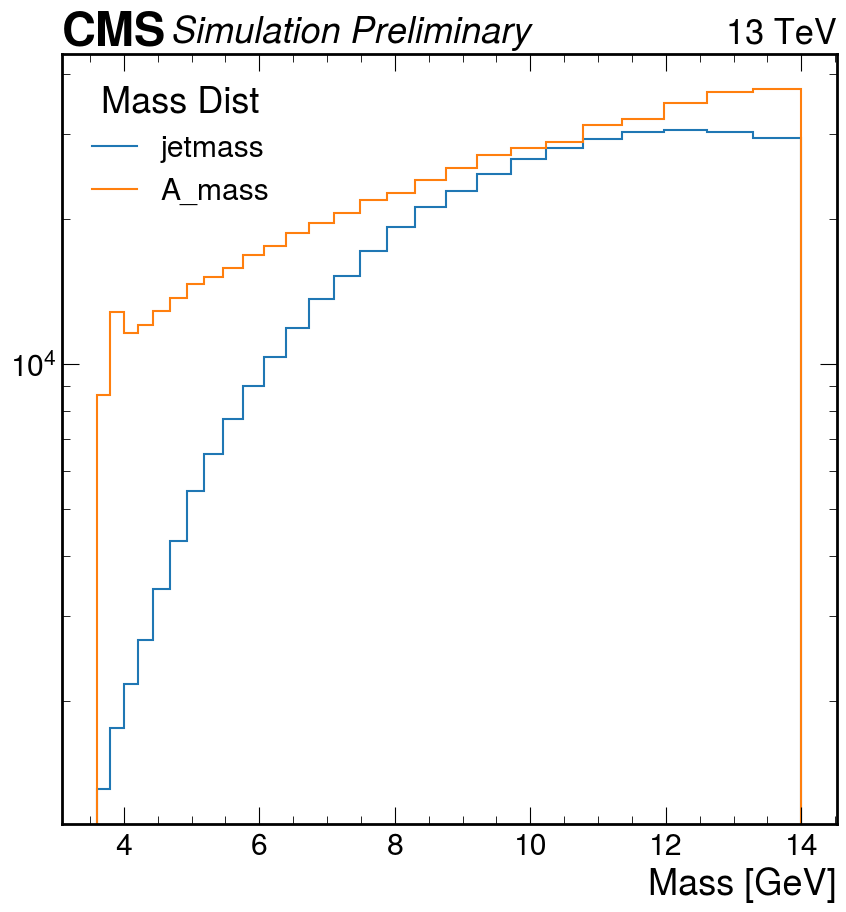

In [144]:
fig, ax = plt.subplots()
out["train_mass"]["mass"].plot1d(ax=ax)
ax.set_yscale("log")
ax.legend(title="Mass Dist")
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

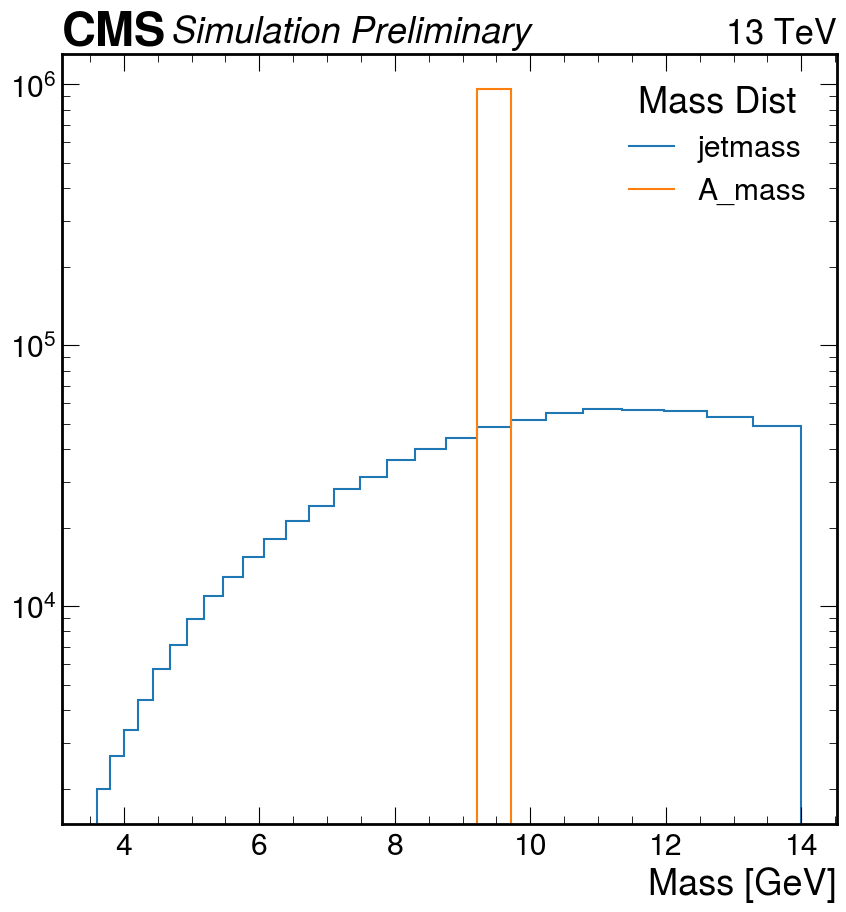

In [145]:
fig, ax = plt.subplots()
out["valid_mass"]["mass"].plot1d(ax=ax)
ax.set_yscale("log")
ax.legend(title="Mass Dist")
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)